**Objetivo**: Carregar e testar a rede neural treinada


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
PATH = '/content/gdrive/Shareddrives/IA901 - Projeto Final/'

Mounted at /content/gdrive


In [2]:
# Criando pasta para salvar resultados preliminares/finais

PATHFinal = PATH+'Notebooks/FinalResults/CancerClassification'

if not os.path.exists(PATHFinal):
  os.mkdir(PATHFinal)

In [11]:
# ______________________________________________________________________________
# Pegando resultados do experimento escolhido

print('Lista de experimentos disponíveis: ', os.listdir(PATH+"Notebooks/InterimResults/CancerClassification/"))
print('Diga o numero do experimento que você gostaria de carregar (Experiment_Name)')
ExperimentName = str (input()) # por ex. 'DL_Baseline'

path_interim = PATH+"Notebooks/InterimResults/CancerClassification/{}".format(ExperimentName)

print('Lista de subexperimentos disponíveis: ', os.listdir(path_interim)[1:])
print('Diga o numero do subexperimento que você gostaria de carregar (Experiment_Number)')
Experiment_Number = str (input())
subpath = path_interim+'/{}'.format(Experiment_Number)

if ExperimentName=='DL_Baseline':
  data_dir = PATH+'Datasets/Processed/TumorClassification/Baseline/'.format(ExperimentName)
else:
  data_dir = PATH+'Datasets/Processed/TumorClassification/{}/'.format(ExperimentName)

Lista de experimentos disponíveis:  ['DL_Baseline', 'Experiment_I', 'Experiment_II']
Diga o numero do experimento que você gostaria de carregar (Experiment_Name)
DL_Baseline
Lista de subexperimentos disponíveis:  ['2', '3', '1']
Diga o numero do subexperimento que você gostaria de carregar (Experiment_Number)
1


In [4]:
PATHFinalExperiment = PATHFinal+'/{}/'.format(ExperimentName)

if not os.path.exists(PATHFinalExperiment):
  os.mkdir(PATHFinalExperiment)

# Configurações gerais e funções úteis para as análises

In [5]:
# Imports

# import the needed libs

from __future__ import print_function, division

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import os
import copy
import re
plt.ion()   # interactive mode

In [6]:
from sklearn import metrics
import pandas as pd
from sklearn.metrics import f1_score

def AnalysisPlots(classe_teste, PrevisoesProb):

  # Construindo a ROC Curve
  # A função abaixo retorna arrays de True Positive Rate (TPR), False Positive Rate (FPR) e os valores de threshold
  FPR, TPR, thresholds = metrics.roc_curve(classe_teste, PrevisoesProb, drop_intermediate=False)

  # Dataframe com indice de Youden:
  DataFrameYouden = pd.DataFrame(data={'Threshold':thresholds,'Youden':TPR - FPR,'TPR':TPR,'FPR':FPR})

  # Dataframe com G-mean:
  DataFrameGmean = pd.DataFrame(data={'Threshold':thresholds,'GMean':np.sqrt(TPR*(1-FPR)),'TPR':TPR,'FPR':FPR})

  # Dataframe com F1-Score:
  DataFrameF1 = pd.DataFrame(data={'Threshold':thresholds,'F1Score':2*TPR*(TPR / (TPR + FPR))/((TPR / (TPR + FPR))+TPR),'TPR':TPR,'FPR':FPR})

  # Dataframe com indice maximo de Youden:
  DataFrameYoudenMax = DataFrameYouden.sort_values(by='Youden', ascending = False) # Ordenando em ordem crescente
  DataFrameGMeanMax = DataFrameGmean.sort_values(by='GMean', ascending = False) # Ordenando em ordem crescente
  DataFrameF1Max = DataFrameF1.sort_values(by='F1Score', ascending = False) # Ordenando em ordem crescente

  # Print do valor de threshold que maximiza o índice de Youden:
  print('\n Melhor Decision Threshold (Youden): ', DataFrameYoudenMax.Threshold.values[0]) # printando valor de threshold que maximiza o Youden
  print('\n Melhor Índice de Youden: ', DataFrameYoudenMax.Youden.values[0]) # printando valor maximo do Youden

  print('\n Melhor Decision Threshold (G-Mean): ', DataFrameGMeanMax.Threshold.values[0]) # printando valor de threshold que maximiza o GMean
  print('\n Melhor Índice G-Mean: ', DataFrameGMeanMax.GMean.values[0]) # printando valor maximo do GMean

  print('\n Melhor Decision Threshold (F1-Score): ', DataFrameF1Max.Threshold.values[0]) # printando valor de threshold que maximiza o GMean
  print('\n Melhor Índice F1-score: ', DataFrameF1Max.F1Score.values[0]) # printando valor maximo do GMean


  # Calculo da AUC
  auc = metrics.roc_auc_score(classe_teste, PrevisoesProb)

  # Plotando ROC Curve com matplotlib:
  fig = plt.figure()
  ax = fig.add_subplot(111)

  ax.plot(FPR, TPR, label="AUC ="+np.format_float_positional(auc, precision=3))
  ax.plot(DataFrameYoudenMax.FPR.values[0], DataFrameYoudenMax.TPR.values[0], label="Max Youden's Index", marker='o')
  ax.plot(DataFrameGMeanMax.FPR.values[0], DataFrameGMeanMax.TPR.values[0], label="Max G-Mean Index", marker='o')
  ax.plot(DataFrameF1Max.FPR.values[0], DataFrameF1Max.TPR.values[0], label="Max F1-Score Index", marker='o')
  ax.plot([0,1], [0,1], linestyle='--', label='Random Selection, AUC = 0.5')
  ax.set_xlabel('False Positive Rate', fontsize=15)
  ax.set_ylabel('True Positive Rate', fontsize=15)
  ax.set_title('ROC Curve', fontsize=15)
  ax.grid()
  ax.legend(loc='lower right')
  plt.savefig(PATHFinalExperiment+'/ROC.png')
  plt.show()

  plt.clf() # limpando janela de plot

  # Plot TPR x Threshold

  fig = plt.figure()
  ax = fig.add_subplot(111)

  ax.plot(thresholds, TPR)
  ax.plot(DataFrameYoudenMax.Threshold.values[0], DataFrameYoudenMax.TPR.values[0], label="Max Youden's Index", marker='o')
  ax.plot(DataFrameGMeanMax.Threshold.values[0], DataFrameGMeanMax.TPR.values[0], label="Max G-Mean Index", marker='o')
  ax.plot(DataFrameF1Max.Threshold.values[0], DataFrameF1Max.TPR.values[0], label="Max F1-Score Index", marker='o')
  ax.set_xlabel('Decision Threshold', fontsize=15)
  ax.set_ylabel('True Positive Rate', fontsize=15)
  ax.set_title('TPR x Decision Threshold', fontsize=15)
  ax.grid()
  ax.set_xlim((0,1.0))
  plt.savefig(PATHFinalExperiment+'/TPRxThreshold.png')
  plt.show()

  plt.clf() # limpando janela de plot

  # Plot FPR x Threshold

  fig = plt.figure()
  ax = fig.add_subplot(111)

  ax.plot(thresholds, FPR)
  ax.plot(DataFrameYoudenMax.Threshold.values[0], DataFrameYoudenMax.FPR.values[0], label="Max Youden's Index", marker='o')
  ax.plot(DataFrameGMeanMax.Threshold.values[0], DataFrameGMeanMax.FPR.values[0], label="Max G-Mean Index", marker='o')
  ax.plot(DataFrameF1Max.Threshold.values[0], DataFrameF1Max.FPR.values[0], label="Max F1-Score Index", marker='o')
  ax.set_xlabel('Decision Threshold', fontsize=15)
  ax.set_ylabel('False Positive Rate', fontsize=15)
  ax.set_title('FPR x Decision Threshold', fontsize=15)
  ax.grid()
  ax.set_xlim((0,1.0))
  plt.savefig(PATHFinalExperiment+'/FPRxThreshold.png')
  plt.show()


  plt.clf() # limpando janela de plot

  return DataFrameYoudenMax.Threshold.values[0], DataFrameGMeanMax.Threshold.values[0], DataFrameF1Max.Threshold.values[0]


In [21]:
def Test_model(model, threshold=0.5):
    model.eval()

    Probabilities = []
    ClassLabels = []
    names = []
    predictions = []

    incorrect_images = []
    incorrect_predictions = []
    incorrect_imagesID = []
    correct_labels = []

    with torch.no_grad():

            # Iterate over data.
            for k, (inputs, labels, paths) in enumerate(dataloaders['test']):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)

                predicted = (outputs > threshold).float()
                _, predicted = torch.max(predicted, 1)

                predictions.extend(predicted.cpu().numpy())

                for i in range(len(labels)):
                    if predicted[i] != labels[i]:
                        incorrect_images.append(inputs[i].cpu().numpy())
                        incorrect_predictions.append(predicted[i].cpu().numpy())
                        correct_labels.append(labels[i].cpu().numpy())

                        temp_0 = re.findall(r'\d+', paths[i].split('/')[11])
                        res_0 = list(map(int, temp_0))
                        incorrect_imagesID.append(res_0[0])

                Probabilities.append(outputs.cpu().detach().numpy()[:,1])
                ClassLabels.append(labels.cpu().detach().numpy())

                for j in range(inputs.size()[0]):
                  temp = re.findall(r'\d+', paths[j].split('/')[11])
                  res = list(map(int, temp))
                  #print('filename: {}, number: {}'.format(paths[j].split('/')[9], res[0]))
                  names.append(res[0])

    # Convert the incorrect images to a numpy array
    incorrect_images = np.array(incorrect_images)

    return np.concatenate(Probabilities).ravel(), np.concatenate(ClassLabels).ravel(), names, incorrect_images, incorrect_predictions, correct_labels, incorrect_imagesID

In [8]:
def VisualizeErrors(incorrect_images, incorrect_predictions, correct_labels, num_images=None):

  if num_images==None:
    num_images = 3
  # Plot the incorrect images
  fig, axs = plt.subplots(1, num_images, figsize=(15, 8))
  axs = axs.flatten()
  for i in range(num_images):
      axs[i].imshow(np.transpose(incorrect_images[i], (1, 2, 0)))
      axs[i].set_title('Predicted: {}, Actual: {}'.format(incorrect_predictions[i], correct_labels[i]))
      axs[i].axis('off')
  plt.savefig(PATHFinalExperiment+"/DL_WrongPredictions.png")
  plt.show()

## Testando o modelo

## Carregar dados


In [9]:
class ImageFolderWithPath(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target, path

In [12]:
# Data augmentation and normalization for training

size, padding = 224, 60 # tamanho de entrada da EfficientNet B1

data_transforms = {
    'test': transforms.Compose([
        transforms.Resize((size,size)),
        transforms.ToTensor()
    ])
}

image_datasets = {x: ImageFolderWithPath(os.path.join(data_dir, x), data_transforms[x]) for x in ['test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=2) for x in ['test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['test']}

class_names = image_datasets['test'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [22]:
# Código que carrega melhor rede neural

# Define your model
model = models.efficientnet_b0(weights=True)
model.classifier[1] = nn.Linear(in_features= model.classifier[1].in_features, out_features=2)

# Add a softmax activation to the output layer
model = nn.Sequential(model, nn.Softmax(dim=1))
model = model.to(device)

# Load your saved model
ModelPATH = subpath+'/Trained_DLModel.pt'
model.load_state_dict(torch.load(ModelPATH, map_location=torch.device('cpu')))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [23]:
# Predicoes:
Predictions, classes, filenames, incorrect_images, incorrect_predictions, correct_labels, incorrect_imagesID = Test_model(model)

<ipython-input-132-42320a3fc045>:18: RuntimeWarning: invalid value encountered in true_divide
  DataFrameF1 = pd.DataFrame(data={'Threshold':thresholds,'F1Score':2*TPR*(TPR / (TPR + FPR))/((TPR / (TPR + FPR))+TPR),'TPR':TPR,'FPR':FPR})



 Melhor Decision Threshold (Youden):  0.0013838604

 Melhor Índice de Youden:  0.5730429430585775

 Melhor Decision Threshold (G-Mean):  0.0013838604

 Melhor Índice G-Mean:  0.7848915964399132

 Melhor Decision Threshold (F1-Score):  6.7011983e-06

 Melhor Índice F1-score:  0.7810384636715774


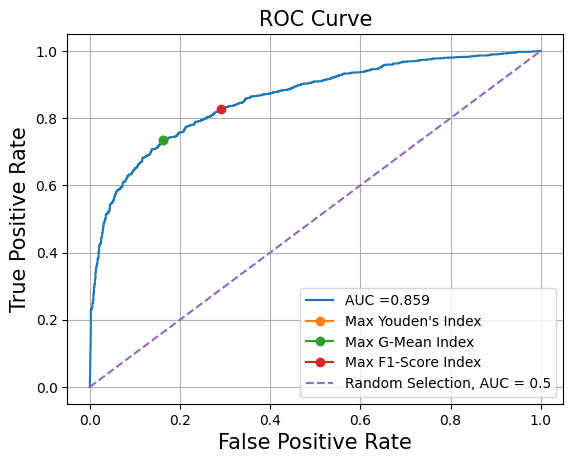

<Figure size 640x480 with 0 Axes>

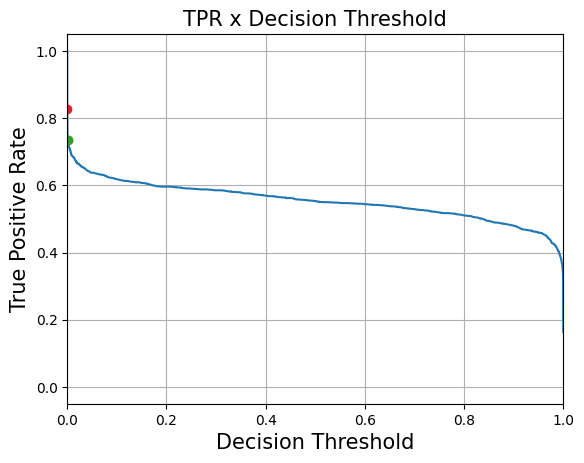

<Figure size 640x480 with 0 Axes>

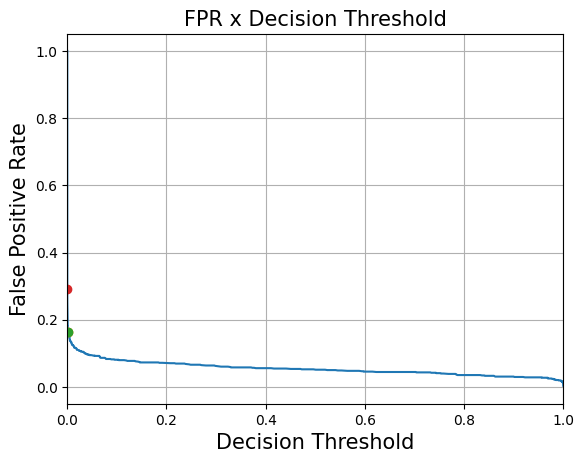

<Figure size 640x480 with 0 Axes>

In [139]:
BestThresholdYouden, BestThresholdGMean, BestThresholdF1 = AnalysisPlots(classes, Predictions)

In [140]:
TestInfos = pd.read_csv("/content/gdrive/Shareddrives/IA901 - Projeto Final/Datasets/Processed/TumorClassification/{}/TestLabels.csv".format(ExperimentName))
result = TestInfos[TestInfos['Unnamed: 0'].isin(filenames)]
result.sort_values('Unnamed: 0', inplace=True)
result

,Unnamed: 0,Types,Class
1585,0,Breast,1.0
2194,1,Breast,1.0
870,2,Breast,1.0
1375,3,Breast,1.0
2021,4,Breast,1.0
...,...,...,...
336,6838,Breast,1.0
1574,6839,Breast,1.0
53,6840,Breast,1.0
1055,6841,Breast,1.0


In [141]:
# Incluindo informacao do tecido sobre as predicoes
TestInfos = pd.read_csv("/content/gdrive/Shareddrives/IA901 - Projeto Final/Datasets/Processed/TumorClassification/{}/TestLabels.csv".format(ExperimentName))
#TestInfos = TestInfos[TestInfos['Unnamed: 0'].isin(filenames)]
TestInfos.sort_values('Unnamed: 0', inplace=True)

# Saving Final predictions
DL_Results = pd.DataFrame({'ImageID':filenames, 'Pred':Predictions, 'Class':classes})
DL_Results.sort_values('ImageID', inplace=True)
DL_Results['Types'] = TestInfos['Types'].values

DL_Results.to_csv(PATHFinalExperiment+"/DL_Prediction.csv", index=False, encoding='utf-8')
DL_Results

,ImageID,Pred,Class,Types
2038,0,0.842914,1,Breast
2321,1,0.999999,1,Breast
1033,2,0.998703,1,Breast
134,3,0.999979,1,Breast
339,4,0.999838,1,Breast
...,...,...,...,...
1797,6838,1.000000,1,Breast
925,6839,1.000000,1,Breast
1217,6840,0.999993,1,Breast
1597,6841,1.000000,1,Breast


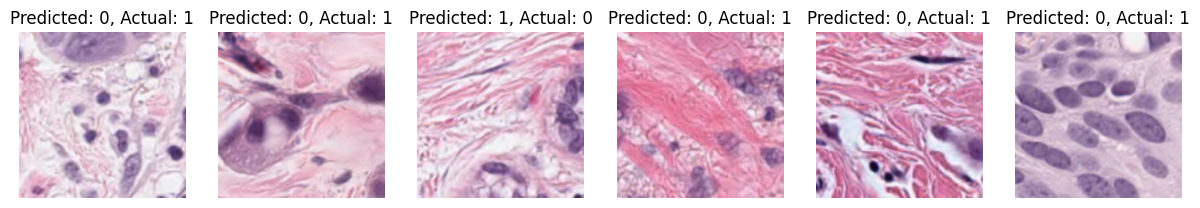

In [65]:
# Visualizando erros cometidos pelo modelo
VisualizeErrors(incorrect_images, incorrect_predictions, correct_labels, num_images=6)

# Análise de qual tecido foi mais difícil de acertar

In [66]:
from collections import Counter

BestThreshold = BestThresholdF1

Classification = DL_Results.copy()

# Classificação baseada no melhor valor de decision threshold obtido via Youden Index!
Classification.loc[Classification["Pred"]>=BestThreshold, "Pred"] = 1
Classification.loc[Classification["Pred"]<BestThreshold, "Pred"] = 0

# Selecionando apenas as linhas com predicoes incorretas
Classification = Classification.loc[Classification["Pred"]!=Classification["Class"]]

print('Quantidade de imagens classificadas incorretamente: ', len(Classification))

# Contando os tipos de cada tecido
TypesTotal = Counter(DL_Results['Types'])
TypesTotal

Quantidade de imagens classificadas incorretamente:  173


Counter({'Breast': 470,
         'Colon': 288,
         'Lung': 36,
         'Kidney': 26,
         'Prostate': 35,
         'Bladder': 29,
         'Stomach': 29,
         'Ovarian': 29,
         'Esophagus': 84,
         'Pancreatic': 39,
         'Uterus': 37,
         'Thyroid': 45,
         'Skin': 37,
         'Cervix': 58,
         'Adrenal_gland': 87,
         'Bile-duct': 84,
         'Testis': 39,
         'HeadNeck': 76,
         'Liver': 44})

In [67]:
# Contando os erros de cada tipo de tecido
Erros = Counter(Classification['Types'])
Erros

Counter({'Breast': 103,
         'Colon': 16,
         'Lung': 1,
         'Thyroid': 3,
         'Cervix': 3,
         'Adrenal_gland': 7,
         'Bile-duct': 14,
         'HeadNeck': 10,
         'Liver': 4,
         'Pancreatic': 3,
         'Prostate': 3,
         'Skin': 1,
         'Testis': 1,
         'Bladder': 1,
         'Stomach': 1,
         'Esophagus': 1,
         'Uterus': 1})

In [68]:
# Printa a porcentagem de erros cometidos para cada tecido

[(i, round(Erros[i] / TypesTotal[i] * 100.0, 2)) for i in Erros]

[('Breast', 21.91),
 ('Colon', 5.56),
 ('Lung', 2.78),
 ('Thyroid', 6.67),
 ('Cervix', 5.17),
 ('Adrenal_gland', 8.05),
 ('Bile-duct', 16.67),
 ('HeadNeck', 13.16),
 ('Liver', 9.09),
 ('Pancreatic', 7.69),
 ('Prostate', 8.57),
 ('Skin', 2.7),
 ('Testis', 2.56),
 ('Bladder', 3.45),
 ('Stomach', 3.45),
 ('Esophagus', 1.19),
 ('Uterus', 2.7)]

# Visualizando imagens classificadas incorretamente por tecido

In [47]:
# Incorrect predictions dataframe
DF_ToPlot = pd.DataFrame(list(zip(incorrect_imagesID, incorrect_predictions, correct_labels)), columns=['ImID', 'Predicted', 'Correct'])
DF_ToPlot.sort_values('ImID', inplace=True)
DF_ToPlot = DF_ToPlot.reset_index()
DF_ToPlot

,index,ImID,Predicted,Correct
0,23,103,1,0
1,78,225,1,0
2,17,304,1,0
3,76,335,1,0
4,21,397,1,0
...,...,...,...,...
98,55,7495,0,1
99,53,7548,0,1
100,73,7552,1,0
101,98,7733,0,1


In [49]:
# Group the images by tissue type
TestInfos = pd.read_csv("/content/gdrive/Shareddrives/IA901 - Projeto Final/Datasets/Processed/TumorClassification/Baseline/TestLabels.csv")
TestInfos = TestInfos[TestInfos['Unnamed: 0'].isin(incorrect_imagesID)]
TestInfos.sort_values('Unnamed: 0', inplace=True)
TestInfos=TestInfos.reset_index()

DF_ToPlot = pd.concat([TestInfos, DF_ToPlot], axis=1)
groups = DF_ToPlot.groupby("Types")


Adrenal_gland
Bile-duct
Bladder
Breast
Cervix
Colon
Esophagus
HeadNeck
Kidney
Liver
Lung
Ovarian
Pancreatic
Prostate
Stomach
Testis
Thyroid
Uterus


In [50]:
DF_ToPlot

,index,Unnamed: 0,Types,Class,index,ImID,Predicted,Correct
0,453,103,Breast,0.0,23,103,1,0
1,422,225,Breast,0.0,78,225,1,0
2,355,304,Breast,0.0,17,304,1,0
3,232,335,Breast,0.0,76,335,1,0
4,568,397,Breast,0.0,21,397,1,0
...,...,...,...,...,...,...,...,...
98,1313,7495,Pancreatic,1.0,55,7495,0,1
99,1362,7548,Prostate,1.0,53,7548,0,1
100,1384,7552,Prostate,0.0,73,7552,1,0
101,1568,7733,Uterus,1.0,98,7733,0,1


In [59]:
# Carregar imagem e respectivas masks

NImages = 1
for i, group in groups:
  print(i)

  ImageIndexDF = group[group.Types==i]
  ImageIndex_0 = ImageIndexDF['ImID'].iloc[:].values
  Predicted_0 = ImageIndexDF['Predicted'].iloc[:].values
  Actual_0 = ImageIndexDF['Correct'].iloc[:].values

  for k in range(0,NImages):

    ImageIndex = ImageIndex_0[k]

    # Carregando imagem e mask
    file_dir = "/content/gdrive/Shareddrives/IA901 - Projeto Final/Datasets/Interim/"
    image_path = os.path.join(file_dir, "Images/Image_"+str(ImageIndex) + '.png')
    masks_path = os.path.join(file_dir, "Masks/Mask_"+str(ImageIndex) + '.npy')

    # Load and plot the image
    image = plt.imread(image_path)
    img_masks = np.load(masks_path)

    Channels = ['{} Image'.format(i), 'Neoplasic', 'Inflammatory','Connective/Soft tissue', 'Dead', 'Epithelial']

    # Plot the incorrect images
    fig, axs = plt.subplots(1, 6, figsize=(15, 8))
    axs = axs.flatten()
    for i in range(6):

        if i==0:
          axs[i].imshow(image)
        else:
          axs[i].imshow(img_masks[:, :, i-1])
          #print('Unique: ', len(np.unique(img_masks[:, :, i-1].astype('uint8')))-1)
        axs[i].set_title('{}'.format(Channels[i]))
        axs[i].axis('off')

    fig.text(0.5, 0.3, 'Predicted: {} \n Actual: {}'.format(Predicted_0[k], Actual_0[0]), ha='center',fontsize=15)
    plt.savefig(PATHFinalExperiment+"/WrongPredictions_Image_{}.png".format(ImageIndex), bbox_inches='tight')
    plt.show()
    plt.clf()

Output hidden; open in https://colab.research.google.com to view.